## Homozygous deletions of paralog vs. singleton passenger genes

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
import analysis_utils as au
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils
%aimport analysis_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

genome_v = 'hg19'
ens_v = '93'

file_annot_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
file_chrom_info = get_local_data_path(['processed'], 'hg19_chrom_info.csv')
file_gene_HDs = get_local_data_path(['processed'], 'all_gene_HDs.csv')
folder_hd_maps = lambda fname: get_local_data_path(['processed','HD_maps'], fname)

### Load annotated genes

In [2]:
genes = pd.read_csv(file_annot_genes)
passenger_genes = genes[~genes.TSG & ~genes.within_driver & ~genes.outside_bounds & ~genes.OG]
driver_genes = genes[genes.TSG | genes.OG]
print('N genes:', genes.shape[0])
print('N TSG:', sum(genes.TSG))
print('N drivers:', sum(genes.TSG | genes.OG))
print('N passenger genes:', passenger_genes.shape[0])
#print('N passenger genes in driver pair:', sum(passenger_genes.in_driver_pair))
print('Paralogs: %d = %.2f%%' % (sum(passenger_genes.paralog), sum(passenger_genes.paralog)/passenger_genes.shape[0]*100))
display(genes[:1])

N genes: 17572
N TSG: 411
N drivers: 652
N passenger genes: 16898
Paralogs: 10588 = 62.66%


,symbol,entrez_id,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,n_paralogs,...,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG,within_driver,outside_bounds
0,A1BG,1,ENSG00000121410,19,58858387,58864802,CCDS12976,6415,58861594.5,NaN,...,False,never,False,False,False,False,False,False,False,False


### Compute number of HDs for each gene

In [3]:
def compute_gene_dels(hd_map, part_hd_map=pd.DataFrame()):
    hds = util.count_dels_per_gene(hd_map, genes)
    if part_hd_map.shape[0]>0:
        partial_hds = util.count_dels_per_gene(part_hd_map, genes).rename(columns={'n_del':'n_part_del'})
        hds = pd.merge(hds, partial_hds[['symbol','n_part_del']])
    passenger_hds = hds[hds.symbol.isin(passenger_genes.symbol)].reset_index(drop=True)
    return hds, passenger_hds

#### 1. TCGA

In [4]:
tcga_hd_map = util.deserialize_map(folder_hd_maps("tcga_hd_map.csv"))
print('N HDs:', tcga_hd_map.shape[0])
print('N samples:', tcga_hd_map[tcga_hd_map.genes.apply(lambda x: len(x)>0)]['patient'].nunique())
tcga_part_hd_map = util.deserialize_map(folder_hd_maps("tcga_part_hd_map.csv"))
tcga_hd_map[:1]

N HDs: 11641
N samples: 2780


,name,patient,cancer_type,barcodeTumour,chr,startpos,endpos,del_len,ploidy,purity,WGD,genes
0,TCGA-02-0001,TCGA-02-0001,GBM,TCGA-02-0001-01C-01D-0182-01,9,21907786,22259623,351837,2.3329,0.58,0,"[1029, 1030]"


In [5]:
print('Median num genes deleted per HD segments:', 
      tcga_hd_map[tcga_hd_map.genes.apply(lambda x: len(x)>0)].genes.apply(lambda x: len(x)).median())

Median num genes deleted per HD segments: 3.0


In [6]:
tcga, tcga_pass = compute_gene_dels(tcga_hd_map, tcga_part_hd_map)
print('N genes deleted 1+ times:', sum(tcga.n_del>=1))
print('N passenger genes deleted 1+ times:', sum(tcga_pass.n_del>=1))
print('N TSGs deleted 1+ times:', sum(tcga[tcga.TSG].n_del>=1))
print('N TSGs deleted 3+ times:', sum(tcga[tcga.TSG].n_del>=3))

N genes deleted 1+ times: 6012
N passenger genes deleted 1+ times: 5747
N TSGs deleted 1+ times: 188
N TSGs deleted 3+ times: 77


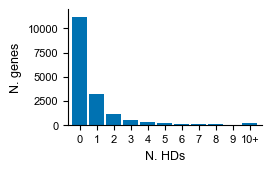

In [7]:
f, ax = plt.subplots(1, 1, figsize=(2.5, 1.5))
tcga_pass.n_del.astype(int).clip(upper=10).value_counts().sort_index().plot.bar(color=gp.get_color('blue'), rot=0, width=.9)
labels = [t.get_text() for t in ax.get_xticklabels()]; labels[10]='10+'; ax.set_xticklabels(labels);
gp.set_axis_props(ax, ylabel='N. genes', xlabel='N. HDs'); ax.set_ylim([0,12000]);

#### Check whether TCGA HDs are all focal

In [8]:
chrom_info = pd.read_csv(file_chrom_info)
chrom_info = chrom_info[~chrom_info.chr.isin(['X','Y'])].astype({'chr':int})
chrom_info['half_arm1_len'] = chrom_info['centStart'] * 0.5
chrom_info['half_arm2_len'] = (chrom_info['size'] - chrom_info['centEnd']) * 0.5

In [9]:
tcga_hd_map2 = pd.merge(tcga_hd_map, chrom_info[['chr','centEnd','half_arm1_len','half_arm2_len']])
tcga_hd_map2['focal'] = tcga_hd_map2.apply(
    lambda x: x.del_len < x.half_arm1_len if x.endpos < x.centEnd else x.del_len < x.half_arm2_len, axis=1)
assert(tcga_hd_map2[tcga_hd_map2.focal==False].shape[0]==0)

#### 2. ICGC

In [10]:
icgc_hd_map = util.deserialize_map(folder_hd_maps("icgc_hd_map.csv"))
print('N samples w/ gene HDs:', icgc_hd_map[icgc_hd_map.genes.apply(lambda x: len(x)>0)]['icgc_donor_id'].nunique())

N samples w/ gene HDs: 525


In [11]:
icgc, icgc_pass = compute_gene_dels(icgc_hd_map)
print('N genes deleted 1+ times:', sum(icgc.n_del>=1))
print('N passenger genes deleted 1+ times:', sum(icgc_pass.n_del>=1))

N genes deleted 1+ times: 2092
N passenger genes deleted 1+ times: 1966


#### 3. All HDs - merge into one large gene deletions resource

In [12]:
all_gene_hds = pd.merge(tcga, icgc[['symbol','n_del']], on='symbol')
all_gene_hds['n_del'] = all_gene_hds.n_del_x + all_gene_hds.n_del_y
passenger_hds = all_gene_hds[all_gene_hds.symbol.isin(passenger_genes.symbol)]
all_gene_hds.to_csv(file_gene_HDs, index=0)

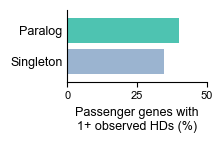

In [13]:
f, ax = plt.subplots(1, 1, figsize=(2.3, 1.5))
ctab = pd.crosstab(passenger_hds.paralog, passenger_hds.n_del>0, normalize='index')*100
ctab.iloc[:,1].plot.barh(ax=ax, color=['#9BB4D0','#4EC3B1'], width=0.8)
ax.set_xlim([0,50]); ax.set_xticks([0,25,50]); ax.set_yticklabels(['Singleton','Paralog'])
gp.set_axis_props(ax, xlabel='Passenger genes with\n1+ observed HDs (%)', ylabel='', ytick_fontsize=9, show_yticks=False)
plt.tight_layout()

In [14]:
print('99th percentile of gene-deleting HD lengths: %.2f Mb (TCGA)' % 
      (tcga_hd_map[tcga_hd_map.genes.apply(lambda x: len(x)>0)].del_len.quantile(0.99)/1000000))

99th percentile of gene-deleting HD lengths: 10.75 Mb (TCGA)


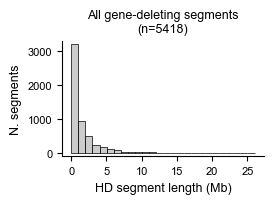

In [15]:
f, ax = plt.subplots(1, 1, figsize=(2.6, 1.5))
df = pd.concat([tcga_hd_map[tcga_hd_map.genes.apply(lambda x: len(x)>0)][['del_len']], 
                icgc_hd_map[icgc_hd_map.genes.apply(lambda x: len(x)>0)][['del_len']]]).reset_index(drop=True)
sns.histplot(df.del_len/1000000, binwidth=1, color='#bbb')
gp.set_axis_props(ax, xlabel='HD segment length (Mb)', ylabel='N. segments', 
                  title='All gene-deleting segments\n(n='+str(df.shape[0])+')'); ax.set_ylim([-100,3300])
plt.savefig('../figures/hg_lengths.png', bbox_inches='tight', dpi=500)

### All passengers HDs -- percentage paralogs

In [16]:
def draw_hd_plot(gene_hds, ax1, ax2, n_del='n_del', title='', bins=['0','1+','3+'], clr='blue', yloc=70):
    df = au.compute_del_proportions(gene_hds, bins=bins, n_del=n_del)
    FET = au.compute_del_FETs(df, bins=bins)
    au.draw_gene_pct_graph(df, ax1, yoffset=12, clr=clr); ax1.set_ylim([0,100])
    au.draw_paralog_pct_graph(df, ax2, gene_hds, xlab='Samples with\ngene HD', clr=clr)
    gp.draw_signif_FET(0,1,yloc,yloc, FET.loc[1,'OR_par'], FET.loc[1,'pval_par'], ax2, color=gp.get_color(clr))
    gp.draw_signif_FET(0,2,yloc+7,yloc+7, FET.loc[2,'OR_par'], FET.loc[2,'pval_par'], ax2, color=gp.get_color(clr))
    ax1.set_title(title, fontsize=9)
    return FET

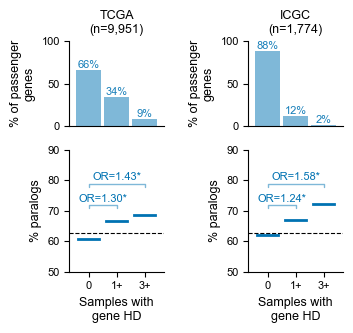

In [17]:
f, ax = plt.subplots(2, 2, figsize=(3.6,3.4), sharex=True, gridspec_kw={'height_ratios':[0.7,1]}); ax=ax.flatten()
FET1 = draw_hd_plot(tcga_pass, ax[0], ax[2], title='TCGA\n(n=9,951)')
FET2 = draw_hd_plot(icgc_pass, ax[1], ax[3], title='ICGC\n(n=1,774)')
plt.tight_layout(w_pad=2)
plt.savefig('../figures/gene_hds.png', bbox_inches='tight', dpi=500, transparent=True)

In [18]:
FET1

,OR_par,pval_par,OR_ess,pval_ess
1,1.304766,4.413041e-15,0.412144,3.014864e-07
2,1.427074,1.832180e-09,0.128166,1.588365e-06


In [19]:
FET2

,OR_par,pval_par,OR_ess,pval_ess
1,1.239104,0.000022,0.260999,0.000036
2,1.578080,0.000686,0.000000,0.035067


#### After filtering out potentially confounding HDs

In [20]:
tcga_hd_map_annot = util.deserialize_map(folder_hd_maps("tcga_hd_map_annot.csv"))

In [21]:
# Recompute gene dels excluding TSG AND fragile site HD events, don't need to filter further from background
tcga_pass_filt = util.count_dels_per_gene(tcga_hd_map_annot[tcga_hd_map_annot['to_drop']==False], passenger_genes)

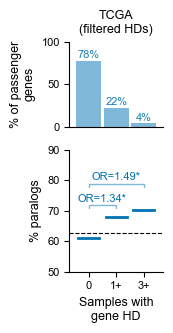

In [22]:
f, ax = plt.subplots(2, 1, figsize=(1.8,3.4), sharex=True, gridspec_kw={'height_ratios':[0.7,1]})
OR = draw_hd_plot(tcga_pass_filt, ax[0], ax[1], title='TCGA\n(filtered HDs)')
plt.tight_layout()
plt.savefig('../figures/tcga_gene_dels_filt.png', bbox_inches='tight', dpi=500, transparent=True)

#### Per cancer type

In [23]:
cancer_types = []
for ct in tcga_hd_map.cancer_type.value_counts().iteritems():
    if ct[1]>600:
        cancer_types.append(ct)

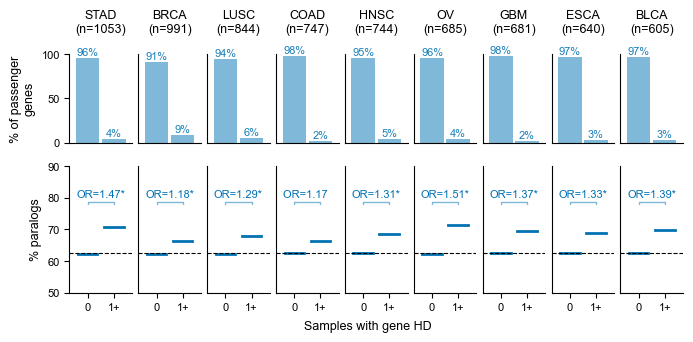

In [24]:
ncts=len(cancer_types)
f, ax = plt.subplots(2, ncts, figsize=(7,3.3), sharex=True, gridspec_kw={'height_ratios':[0.7,1]}); ax=ax.flatten()
for i, ct in enumerate(cancer_types):
    gene_dels_ct = util.count_dels_per_gene(tcga_hd_map[tcga_hd_map.cancer_type==ct[0]], passenger_genes)
    df = au.compute_del_proportions(gene_dels_ct, bins=['0','1+'])
    FET = au.compute_del_FETs(df, bins=['0','1+'])
    au.draw_gene_pct_graph(df, ax[i], yoffset=12); ax[i].set_ylim([0,100])
    au.draw_paralog_pct_graph(df, ax[i+ncts], passenger_genes)
    gp.draw_signif_FET(0, 1, 77, 77, FET.loc[1,'OR_par'], FET.loc[1,'pval_par'], ax[i+ncts], color=gp.get_color('blue'))
    if i > 0: 
        gp.set_axis_props(ax[i], ylabel='', show_yticks=False, show_yticklabels=False)
        gp.set_axis_props(ax[i+ncts], ylabel='', show_yticks=False, show_yticklabels=False)
    ax[i].set_title(ct[0]+'\n(n='+str(ct[1])+')\n', fontsize=9); ax[i+ncts].set_xlabel('')
f.text(0.53, 0, 'Samples with gene HD', rotation=0, va="center", ha='center', fontsize=9)
plt.tight_layout(w_pad=0.5)
plt.savefig('../figures/tcga_gene_dels_by_cancer.png', bbox_inches='tight', dpi=500)

### Paralog passenger HDs -- % essential vs. non-essential paralogs

In [25]:
def draw_hd_ess_plot(gene_hds, ax, ess_col, title='', bins=['0','1+','3+'], yoffset=0.5):
    gene_hds = gene_hds.dropna(subset=[ess_col])
    df = au.compute_del_proportions(gene_hds, ess_col=ess_col, bins=bins)
    FET = au.compute_del_FETs(df, bins=bins)
    au.draw_ess_paralog_pct_graph(df, ax, gene_hds, ess_col=ess_col, title=title+'\n(n='+str(sum((gene_hds[ess_col]==True) & (gene_hds['paralog']==True) ))+')')
    yloc = df.iloc[0,1]+yoffset
    gp.draw_signif_FET(0, 1, yloc, yloc, FET.loc[1,'OR_ess'], FET.loc[1,'pval_ess'], ax, yoffset=.9, color=gp.get_color('do'))
    gp.draw_signif_FET(0, 2, yloc+2, yloc+2, FET.loc[2,'OR_ess'], FET.loc[2,'pval_ess'], ax,yoffset=.9,color=gp.get_color('do'))
    return FET

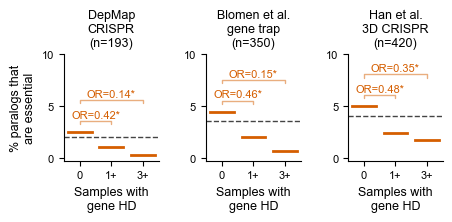

In [26]:
f, ax = plt.subplots(1, 3, figsize=(4.6,2.3))
FET=draw_hd_ess_plot(tcga_pass, ax[0], ess_col='depmap_ess', title='DepMap\nCRISPR')
draw_hd_ess_plot(tcga_pass, ax[1], ess_col='ess_gt', title='Blomen et al.\ngene trap')
draw_hd_ess_plot(tcga_pass, ax[2], ess_col='ess_3D', title='Han et al.\n3D CRISPR')
for i in range(0,3): ax[i].set_ylim([-.2,10])
for i in range(1,3): ax[i].set_ylabel('')
plt.tight_layout(w_pad=2)
plt.savefig('../figures/tcga_essential_dels.png', bbox_inches='tight', dpi=500)

In [27]:
FET

,OR_par,pval_par,OR_ess,pval_ess
1,1.274277,3.318028e-12,0.422441,6.146895e-07
2,1.332752,2.802670e-06,0.136523,3.386248e-06


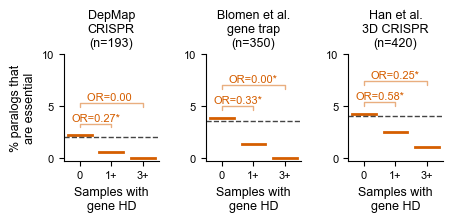

In [28]:
f, ax = plt.subplots(1, 3, figsize=(4.6,2.3))
FET=draw_hd_ess_plot(icgc_pass, ax[0], ess_col='depmap_ess', title='DepMap\nCRISPR')
draw_hd_ess_plot(icgc_pass, ax[1], ess_col='ess_gt', title='Blomen et al.\ngene trap')
draw_hd_ess_plot(icgc_pass, ax[2], ess_col='ess_3D', title='Han et al.\n3D CRISPR')
for i in range(0,3): ax[i].set_ylim([-.2,10])
for i in range(1,3): ax[i].set_ylabel('')
plt.tight_layout(w_pad=2)
plt.savefig('../figures/icgc_essential_dels.png', bbox_inches='tight', dpi=500)

In [29]:
FET

,OR_par,pval_par,OR_ess,pval_ess
1,1.186124,0.001025,0.269626,0.000073
2,1.316320,0.057305,0.000000,0.083132


### Gene length vs. n deletions

In [30]:
print('Full:', stats.spearmanr(tcga_pass.cds_len, tcga_pass.n_del))
print('Partial:', stats.spearmanr(tcga_pass.cds_len, tcga_pass.n_part_del))

Full: SpearmanrResult(correlation=0.030711724135319654, pvalue=6.526063804636395e-05)
Partial: SpearmanrResult(correlation=0.1610324553875208, pvalue=1.5291093884940336e-98)


MannwhitneyuResult(statistic=34648733.0, pvalue=2.790181674651483e-05)
Avg length: 57.8kb vs. 42.4kb


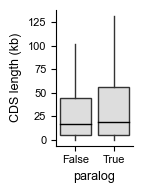

In [31]:
f, ax = plt.subplots(1, 1, figsize=(1.5,2), sharey=True)
print(stats.mannwhitneyu(genes[genes.paralog].cds_len, genes[~genes.paralog].cds_len))
print('Avg length: %.1fkb vs. %.1fkb' % (genes[genes.paralog].cds_len.mean()/1000, genes[~genes.paralog].cds_len.mean()/1000))
df = genes.assign(cds_len = genes.cds_len/1000)
sns.boxplot(data=df, x='paralog', y='cds_len', showfliers=False, **gp.get_boxplot_props(), ax=ax, color='#ddd')
ax.set_ylabel('CDS length (kb)')
plt.tight_layout()